# Defect Classifications of AOI

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Data preprocess

In [2]:
test_df = pd.read_csv('aoi/test.csv')
test_df.loc[0, "Label"]

nan

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = False):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "ID"]
        label = self.df.loc[index, "Label"].item()
        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [48]:
train_dataset = CustomDataset('aoi/train.csv','aoi/train_images', transform=train_transform)
test_dataset = CustomDataset('aoi/test.csv','aoi/test_images', transform=test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=18, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)   

In [6]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([18, 1, 512, 512])
torch.Size([18])


## 2. PSPNet Model
- extract feature based on Conv
- Use Pyramid Pooling, Onebyone Conv
- Append Upsampling
- Conv + Linear to classify
- all from scratch

In [13]:
EPOCHS = 10

In [9]:
class TextureCNN(nn.Module):
    def __init__(self, num_classes):
        super(TextureCNN, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # output size (N, 16, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 16, 256, 256)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # output size (N, 32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 128, 128)
        )
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 32, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 32, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 32, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 32, 6, 6)
        self.con1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.con2 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.con3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.con4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=128/1, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample2 = nn.Upsample(scale_factor=128/2, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample3 = nn.Upsample(scale_factor=128/3, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        self.upsample4 = nn.Upsample(scale_factor=128/6, mode='bilinear', align_corners=True) # output size (N, 1, 128, 128)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=36, out_channels=18, kernel_size=3, stride=2, padding=1), # output size (N, 18, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 18, 32, 32)
            nn.Conv2d(in_channels=18, out_channels=9, kernel_size=3, stride=2, padding=1), # output size (N, 9, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 9, 8, 8)
            nn.Flatten(), # output size (N, 9 * 8 * 8)
            nn.Linear(9 * 8 * 8, 128), # output size (N, 128)
            nn.ReLU(),
            nn.Linear(128, num_classes), # output size (N, 6)
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.con1(x1) 
        x2 = self.pool2(x)
        x2 = self.con2(x2)
        x3 = self.pool3(x)
        x3 = self.con3(x3)
        x4 = self.pool4(x)
        x4 = self.con4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 36, 128, 128)
        
        # Classifier
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextureCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = []

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), loss_list, label="train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

## 3. Baseline
- extract feature based on Conv
- Linear to classify
- all from scratch

In [28]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        
        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3, padding=1), # output size (N, 32, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 32, 256, 256)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # output size (N, 64, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 128, 128)
        )
        
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(), # output size (N, 1 * 8 * 8)
            nn.Linear(64 * 128 * 128, 128), # output size (N, 64)
            nn.ReLU(),
            nn.Linear(128, num_classes), # output size (N, 6)
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        # CNN layers
        x = self.features(x)
        
        # Classifier
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_list = []

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

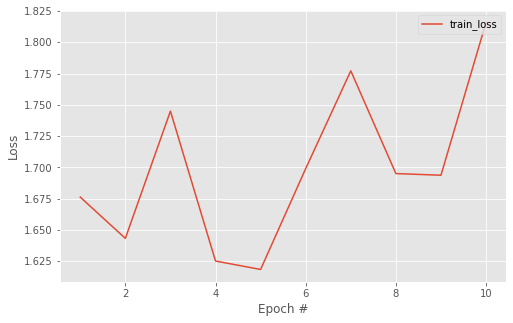

In [24]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), loss_list, label="train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

## 4. ResNet 18
- first layer 3 channels change to 1 channel
- last append a new linear 
    - input size 1000 
    - output size class_num=6
- only train above 2 layers, other layer use pretrained ResNet18

In [33]:
# 檢視 ResNet18 模型結構
net = models.resnet18()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Modify the classification layer
        self.classifier = nn.Linear(self.resnet.fc.out_features, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the optimizer for fine-tuning using Adam with a single learning rate
fine_tune_params = list(model.resnet.conv1.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.Adam(fine_tune_params, lr=0.001, betas=(0.9, 0.999))

loss_list = []

for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

/Users/howard/miniconda3/envs/texture/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/howard/miniconda3/envs/texture/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.5922
Epoch [2/10], Loss: 0.6332
Epoch [3/10], Loss: 0.1445
Epoch [4/10], Loss: 0.0990
Epoch [5/10], Loss: 0.0346
Epoch [6/10], Loss: 0.4774
Epoch [7/10], Loss: 0.7019
Epoch [8/10], Loss: 0.0498
Epoch [9/10], Loss: 0.0538
Epoch [10/10], Loss: 0.2409


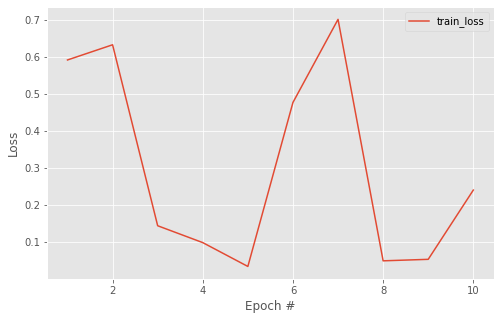

In [40]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), loss_list, label="train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

In [42]:
torch.save(model, 'model/ResNet18_epoch10_local.pt')

## 5. ResNet18 with PSPNet v1 idea
- first layer 3 channels change to 1 channel
- last append Pyramid Pooling layers, Onebyone Conv and Upsampling before ResNet18 layer4
- Conv + Linear to classify
- Train above 3 layers, other layer use pretrained ResNet18

In [60]:
class ResNetPSPNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNetPSPNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze the layers except the new conv1 and the classification layer
        for name, param in self.resnet.named_parameters():
            if 'conv1' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Spatial Pyramid Pooling layers
        self.pool1 = nn.AdaptiveMaxPool2d((1, 1)) # output size (N, 512, 1, 1)
        self.pool2 = nn.AdaptiveMaxPool2d((2, 2)) # output size (N, 512, 2, 2)
        self.pool3 = nn.AdaptiveMaxPool2d((3, 3)) # output size (N, 512, 3, 3)
        self.pool4 = nn.AdaptiveMaxPool2d((6, 6)) # output size (N, 512, 6, 6)
        self.onebyonecon1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 1, 1)
        self.onebyonecon2 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 2, 2)
        self.onebyonecon3 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 3, 3)
        self.onebyonecon4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0) # output size (N, 1, 6, 6)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=16/1, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample2 = nn.Upsample(scale_factor=16/2, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample3 = nn.Upsample(scale_factor=16/3, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        self.upsample4 = nn.Upsample(scale_factor=16/6, mode='bilinear', align_corners=True) # output size (N, 1, 16, 16)
        # Conv Classifier layers
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=516, out_channels=128, kernel_size=3, stride=2, padding=1), # output size (N, 128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 128, 4, 4)
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1), # output size (N, 64, 2, 2)
            nn.ReLU(),
            nn.MaxPool2d(2), # output size (N, 64, 1, 1)
            nn.Flatten(), # output size (N, 64 * 1 * 1)
            nn.Linear(64, num_classes), # output size (N, 6)
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Spatial Pyramid Pooling
        x1 = self.pool1(x)
        x1 = self.onebyonecon1(x1) 
        x2 = self.pool2(x)
        x2 = self.onebyonecon2(x2)
        x3 = self.pool3(x)
        x3 = self.onebyonecon3(x3)
        x4 = self.pool4(x)
        x4 = self.onebyonecon4(x4)
        
        # Upsampling
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x3 = self.upsample3(x3)
        x4 = self.upsample4(x4)
        
        # Concatenate the pooled features
        x = torch.cat((x1, x2, x3, x4, x), dim=1) # output size (N, 516, 16, 16)
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
num_classes = 6
model = ResNetPSPNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the optimizer for fine-tuning using Adam with a single learning rate

# Create a list of parameters to optimize (conv1 and classifier)
parameters_to_optimize = [
    {'params': model.resnet.conv1.parameters()},
    {'params': model.onebyonecon1.parameters()},
    {'params': model.onebyonecon2.parameters()},
    {'params': model.onebyonecon3.parameters()},
    {'params': model.onebyonecon4.parameters()},
    {'params': model.classifier.parameters()},
    
]
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001, betas=(0.9, 0.999))

loss_list = []

for epoch in range(EPOCHS):
    model.train()
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1) % 1 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

## # Validation

In [77]:
def validate(model_path, csv_filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.append(predicted.item())
            
    test_df['Label'] = predicted_list
    test_df.to_csv(f'result/predict_{csv_filename}.csv', index=False)

In [79]:
def train_accuracy(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"{model_path}, Train Accuracy: {accuracy:.2f}%")

In [43]:
train_accuracy('model/ResNet18_epoch10_local.pt')

Train Accuracy: 62.34%


In [55]:
validate('model/ResNet18_epoch10_local.pt', 'ResNet18_epoch10_local') # test result = 0.5977

100%|██████████| 10142/10142 [09:38<00:00, 17.52it/s]


In [47]:
train_accuracy('model/ResNet18_epoch30_kaggle.pt')

100%|██████████| 141/141 [05:21<00:00,  2.28s/it]

Kaggle Train Accuracy: 92.29%


In [49]:
validate('model/ResNet18_epoch30_kaggle.pt', 'ResNet18_epoch30_kaggle') # test result = 0.8996

100%|██████████| 10142/10142 [09:49<00:00, 17.21it/s]


In [81]:
train_accuracy('model/ResNet18_epoch100_kaggle.pt')

100%|██████████| 141/141 [05:33<00:00,  2.36s/it]

model/ResNet18_epoch100_kaggle.pt, Train Accuracy: 83.98%


In [80]:
train_accuracy('model/ResNetPSPNet_epoch100_kaggle.pt')

100%|██████████| 141/141 [05:33<00:00,  2.36s/it]

model/ResNetPSPNet_epoch100_kaggle.pt, Train Accuracy: 93.51%


In [82]:
validate('model/ResNetPSPNet_epoch100_kaggle.pt', 'ResNetPSPNet_epoch100_kaggle') # test result =

100%|██████████| 10142/10142 [09:49<00:00, 17.21it/s]
